<a href="https://colab.research.google.com/github/now1256/pythonProject/blob/master/20230118ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install install torch==1.8.0 torchtext==0.9.0
 !pip install Konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 17.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.8.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.8.0 which is incompatible.
Looking in indexes: https://pypi.org/

In [2]:
import os
import re
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import urllib.request
from nltk import FreqDist
import pandas as pd
import numpy as np
from konlpy.tag import Okt
import matplotlib.pyplot as plt
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle 


In [3]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", DEVICE)

cpu와 cuda 중 다음 기기로 학습함: cuda


In [4]:
# txt파일을 다운 받음 
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

# pandas를 이용하여 data를 따로 저장해놓음
train_data=pd.read_table('ratings_train.txt')
test_data=pd.read_table('ratings_test.txt')

In [5]:
#피클화 데이터 토큰이 너무 오래걸려서
def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def save_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

In [6]:
# 훈련용 리뷰 개수 출력
print('훈련용 리뷰 개수 :',len(train_data))

# 테스트용 리뷰 개수
print('테스트용 리뷰 개수 :',len(test_data))

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


In [7]:
# 4000개 정도 중복 됨 label은 0,1값 2개만 존재 
print(train_data['document'].nunique(), train_data['label'].nunique())

146182 2


In [8]:
# doucument 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [9]:
# 전체 샘플 확인
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


In [10]:
# 정확 한 값의 개수
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [11]:
# null 값 확인
print("null값의 존재 여부 :", train_data.isnull().sum())

null값의 존재 여부 : id          0
document    1
label       0
dtype: int64


In [12]:
#Null 값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any')

In [13]:
#Null 값이 존재하는 지 확인
print("Null 값 존재: ",train_data.isnull().values.any())

Null 값 존재:  False


In [14]:
#Null 값을 가진 샘플 제거 됬는지 확인 -> 1개가 줄었으면 맞음 
print(len(train_data))

146182


In [15]:
# 데이터 전처리
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-15-28e68038176e>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [16]:
#공백인 empty칸을 null로 바꿔줌
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


<ipython-input-16-dca8c273f009>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "")


In [17]:
#특수기호를 제외하니 생긴 Null 값을 제거
train_data = train_data.dropna(how = 'any')
print("특수 기호를 제외한 나머지 데이터 값",len(train_data))

특수 기호를 제외한 나머지 데이터 값 145393


In [18]:
#테스트 셋도 위와 같이 전처리
#중복제거
test_data.drop_duplicates(subset = ['document'], inplace=True)
#한글과 공백뺴고 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# empty space- > null
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True)
# null값 제거
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


<ipython-input-18-ae8dd1d24807>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-18-ae8dd1d24807>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "")


In [19]:
# 불용어 stopwords -> 형태소 분리할때 효율적으로 할 수 있게 제거 
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [20]:
# 형태소 분석기 KoNLPy의 Okt를 사용
okt = Okt()

In [21]:
X_train = []
for sentence in tqdm(train_data['document']):
    #stem=True의 경우 어느정도 정규화를 해줌
    tokenized_sentence = okt.morphs(sentence, stem=True)
    # for문 한줄로 이거 공부해야함
    # 불용어 제거를 함
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)
print(X_train[:3])

100%|██████████| 145393/145393 [09:53<00:00, 244.89it/s]

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [22]:
# testset 또한 같이 토큰화 해놓음
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if word not in stopwords]
    X_test.append(stopwords_removed_sentence)
print(X_test[:3])    

100%|██████████| 48852/48852 [03:28<00:00, 234.49it/s]

[['굳다', 'ㅋ'], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]


In [23]:
# 정수 인코딩
# 빈도수 계산 도구 FreqDist()
vocab = FreqDist(np.hstack(X_train))
print('단어 집합의 크기 : {}'.format(len(vocab)))

단어 집합의 크기 : 43752


In [24]:
vocab_size = 19416
# 상위 vocab_size개의 단어만 보존 vocab size 줄임 
vocab = vocab.most_common(vocab_size)
print('단어 집합의 크기 : {}'.format(len(vocab)))

단어 집합의 크기 : 19416


In [25]:
# enumerate()는 순서가 있는 자료형(list, set, tuple, dictionary, string)을 입력으로 받아 인덱스를 순차적으로 함께 리턴한
# 0은 패딩 1은 모르는 값
word_to_index = {word[0] : index + 2 for index, word in enumerate(vocab)}
word_to_index['pad'] = 0
word_to_index['unk'] = 1

In [26]:
# X_train 단어집합
encoded = []
for line in X_train: #입력 데이터에서 1줄씩 문장을 읽음
    temp = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
      try:
        temp.append(word_to_index[w]) # 글자를 해당되는 정수로 변환
      except KeyError: # 단어 집합에 없는 단어일 경우 unk로 대체된다.
        temp.append(word_to_index['unk']) # unk의 인덱스로 변환

    encoded.append(temp)
X_train = encoded    
print(X_train[:10])
print(vocab_size)

[[51, 455, 17, 261, 660], [934, 458, 42, 603, 2, 215, 1450, 25, 962, 676, 20], [387, 2445, 1, 2316, 5672, 3, 223, 10], [6493, 106, 8119, 219, 57, 5, 27, 3604], [1024, 19417, 30, 9146, 25, 834, 2, 2580, 22, 1109, 241, 14244, 1, 1077, 255, 241], [723, 5673, 981, 1388, 428, 144, 1693, 1627, 11561, 226, 2, 93, 127, 1082, 46, 246], [214, 315, 4, 325, 483], [127, 1082, 46, 333, 24, 9787, 14245, 299, 124, 1586, 369, 120, 227, 11, 798, 18, 580, 575, 519, 476, 3118, 8120, 15, 1389, 1389, 38, 286, 5, 25, 36, 41, 15, 704, 1073, 70], [95, 5, 57, 7, 369, 98, 2], [1536, 27, 202, 536, 83, 15, 393, 1440, 362, 667, 9, 5674, 7]]
19416


In [27]:
# X_test 단어집합 
vocab = FreqDist(np.hstack(X_test))
vocab_size = 19416
vocab = vocab.most_common(vocab_size)
word_to_index = {word[0] : index + 2 for index, word in enumerate(vocab)}
word_to_index['pad'] = 0
word_to_index['unk'] = 1
encoded = []
for line in X_test: #입력 데이터에서 1줄씩 문장을 읽음
    temp = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
      try:
        temp.append(word_to_index[w]) # 글자를 해당되는 정수로 변환
      except KeyError: # 단어 집합에 없는 단어일 경우 unk로 대체된다.
        temp.append(word_to_index['unk']) # unk의 인덱스로 변환

    encoded.append(temp)
X_test = encoded    

print(X_test[:10])
print(vocab_size)

[[614, 92], [65, 168, 24, 395, 20, 21, 280, 776, 45, 861, 18], [67, 20, 90, 380, 110, 112, 61, 151, 246], [14, 18, 127, 1784, 111, 61, 37, 19, 25, 176, 14706, 797], [226, 3159, 12, 29, 226, 2], [748, 72], [1090, 401, 302, 22, 2807, 10898, 5, 1785, 2808, 2180, 3624, 2605], [457, 1200, 12, 2128, 228, 54, 5, 2809, 694, 183, 48, 99, 2319, 228, 14707, 52, 396, 10899, 17, 2, 85, 421, 52, 2379, 6], [2702, 1639, 452, 3042, 579, 2703, 5458, 224, 40, 74, 20], [135, 339, 14, 7584, 14708, 390, 62]]
19416


In [28]:
# label값 받기 
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [29]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_train = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [30]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145391
145391


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [31]:
X_test = np.delete(X_test, drop_train, axis=0)
y_test = np.delete(y_test, drop_train, axis=0)
print(len(X_test))
print(len(y_test))

48850
48850


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.001258674883589


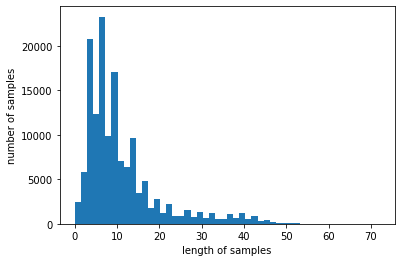

In [32]:
# 패딩
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [33]:
# max len을 확인하는 함수 
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [34]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.08354024664526


In [35]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
print("X_train의 shape: ",X_train.shape)
print("X_test의 shape: ",X_test.shape)

X_train의 shape:  (145391, 30)
X_test의 shape:  (48850, 30)


In [36]:
# train set과 val set x, y 분리 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, shuffle=False, random_state=1004)

In [37]:
# 텐서 변환
X_train = torch.LongTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.LongTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.LongTensor(X_test)
y_test = torch.LongTensor(y_test)
print(X_train.shape,y_train.shape)

torch.Size([87234, 30]) torch.Size([87234])


In [38]:
# 토체의 데이터 셋에 넣음 
train_data = TensorDataset(X_train, y_train)
var_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

In [39]:
# 데이터로더를 만듬 
train_data_dataloader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
val_data_dataloader = DataLoader(dataset=var_data,batch_size=256, shuffle=True)
test_data_dataloader = DataLoader(dataset=test_data,batch_size=256, shuffle=True)


In [40]:
# RNN 모델 구현 

# 시드 고정
SEED = 5
random.seed(SEED)  
torch.manual_seed(SEED)

# 하이퍼파라미터
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10

In [41]:
# GRU를 이용 
class GRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(n_vocab, embed_dim, padding_idx=0)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x): 
        x = self.embed(x)  # 이것때문에 에러가 났음 
        h_0 = self._init_state(batch_size=x.size(0))  # 첫번째 히든 스테이트를 0벡터로 초기화
        x, _ = self.gru(x, h_0)  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)
        h_t = x[:, -1, :]  # (배치 크기, 은닉 상태의 크기)의 텐서로 크기가 변경됨. 즉, 마지막 time-step의 은닉 상태만 가져온다.
        self.dropout(h_t)
        logit = self.out(h_t)  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)
        return logit

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()


In [42]:
model = GRU(1, 256, 19418, 128, 2, 0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [43]:
def train(model, optimizer, train_data_dataloader):
    model.train()
    for batch_idx, samples in (enumerate(train_data_dataloader)):
        x, y = samples
        # y.data.sub_(1)  # 레이블 값을 0과 1로 변환
        optimizer.zero_grad()
        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()

In [44]:
def evaluate(model, val_data_dataloader):
    model.eval()
    corrects, total_loss = 0, 0
    for batch_idx, samples in enumerate(val_data_dataloader):
        x, y = samples
        # y.data.sub_(1) # 레이블 값을 0과 1로 변환
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_data_dataloader.dataset) # 이거 뭘 가르키는지 모르겠음 
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [45]:
best_val_loss = None
print("학습 시작!!!!")
for e in range(1, EPOCHS):
    train(model, optimizer, train_data_dataloader) 
    val_loss, val_accuracy = evaluate(model, val_data_dataloader)
    print("[Epoch: %d] val loss : %5.2f | val accuracy : %5.2f" % (e, val_loss, val_accuracy))

    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss
   


학습 시작!!!!
[Epoch: 1] val loss :  0.42 | val accuracy : 80.60
[Epoch: 2] val loss :  0.38 | val accuracy : 82.96
[Epoch: 3] val loss :  0.37 | val accuracy : 83.80
[Epoch: 4] val loss :  0.39 | val accuracy : 83.91
[Epoch: 5] val loss :  0.44 | val accuracy : 83.24
[Epoch: 6] val loss :  0.54 | val accuracy : 83.07
[Epoch: 7] val loss :  0.63 | val accuracy : 82.61
[Epoch: 8] val loss :  0.79 | val accuracy : 83.04
[Epoch: 9] val loss :  0.84 | val accuracy : 82.59


In [46]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_data_dataloader)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' % (test_loss, test_acc))

테스트 오차:  1.00 | 테스트 정확도: 55.81


In [47]:
tokenizer = Tokenizer()

def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  
  encoded = tokenizer.texts_to_sequences([new_sentence])
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len ) # 패딩
  pad_new = torch.LongTensor(pad_new)
  print(pad_new.shape)
  print(pad_new)
  score = float(model(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
text = input('영화리뷰를 써주세요 : ')
print(text)
sentiment_predict(text)